In [ ]:
# All imports
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
from fastai.imports import *
from fastai.vision.all import *
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow import keras
from PIL import Image
from numpy import asarray
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.applications import mobilenet
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from scipy.io import loadmat 
import cv2
import random
import gc 
from sklearn.utils import shuffle
import itertools

In [ ]:
# Retrieving files from our Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Unzipping feature images into colab
!unzip '/content/drive/My Drive/NNDL Project Submission/im.zip'

Streaming output truncated to the last 5000 lines.
  inflating: im/image_06851.jpg      
  inflating: __MACOSX/im/._image_06851.jpg  
  inflating: im/image_07597.jpg      
  inflating: __MACOSX/im/._image_07597.jpg  
  inflating: im/image_06689.jpg      
  inflating: __MACOSX/im/._image_06689.jpg  
  inflating: im/image_01680.jpg      
  inflating: __MACOSX/im/._image_01680.jpg  
  inflating: im/image_01858.jpg      
  inflating: __MACOSX/im/._image_01858.jpg  
  inflating: im/image_03097.jpg      
  inflating: __MACOSX/im/._image_03097.jpg  
  inflating: im/image_02389.jpg      
  inflating: __MACOSX/im/._image_02389.jpg  
  inflating: im/image_04920.jpg      
  inflating: __MACOSX/im/._image_04920.jpg  
  inflating: im/image_03083.jpg      
  inflating: __MACOSX/im/._image_03083.jpg  
  inflating: im/image_04934.jpg      
  inflating: __MACOSX/im/._image_04934.jpg  
  inflating: im/image_01694.jpg      
  inflating: __MACOSX/im/._image_01694.jpg  
  inflating: im/image_06845.jpg     

In [ ]:
# Input for the labels of our images
labels = '/content/drive/My Drive/NNDL Project/imagelabels.mat'
image_labels = loadmat(labels)

In [ ]:
# Adding our image_labels into a dataframe to match with our images
df = pd.DataFrame()
labels = image_labels['labels'].transpose()
labels = labels -1
df = pd.DataFrame(labels, columns = ['image_label'])

In [ ]:
# Finding image paths for each image_label and adding it as a column to our dataframe
image_path = []
for i in range (1,len(labels)+1):
  if i<10:
    x = '0000' + str(i)
  elif i<100:
    x = '000' + str(i)
  elif i<1000:
    x = '00' + str(i)
  elif i<10000:
    x = '0' + str(i)
  else:
    break
  image_path.append('/content/im/image_'+x+'.jpg')

df["image_path"] = image_path 

In [ ]:
# We can see there are images belonging to 102 different classes of flowers
df.image_label.value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: image_label, Length: 102, dtype: int64

In [ ]:
# Dataframe format - image paths (feature) and corresponding image labels (target)
print(df)

      image_label                   image_path
0              76  /content/im/image_00001.jpg
1              76  /content/im/image_00002.jpg
2              76  /content/im/image_00003.jpg
3              76  /content/im/image_00004.jpg
4              76  /content/im/image_00005.jpg
...           ...                          ...
8184           61  /content/im/image_08185.jpg
8185           61  /content/im/image_08186.jpg
8186           61  /content/im/image_08187.jpg
8187           61  /content/im/image_08188.jpg
8188           61  /content/im/image_08189.jpg

[8189 rows x 2 columns]


In [ ]:
# Test to see whether the path code works to open the 1st image
im = Image.open(df['image_path'][1])
width, height = im.size
print(width,height)

625 500


## INPUT PROCESSING FOR SIAMESE MODEL : GENERATION OF TRIPLETS

Our aim is to use a Siamese Network using triplet loss function to improve the relatively poor results of few shot learning (using much fewer training samples). 

For any kind of deep neural network to perform well, it requires a lot of training data. We see a stark fall in classification accuracy (from ~97% to ~80%) when the same EfficientNet transfer learning network was trained on ~5.7k images vs ~1.5k images.

To solve the problem of fewer training data, we leverage on a special network architecture called Siamese Network. A Siamese Network uses only a few numbers of images to get better predictions.

Instead of learning to classify images to a certain class, the model learns to find embeddings for images such that images from the same class are close but images of different classes are further apart.

The model uses input samples in the form of triplets consisting of 3 images - an anchor image (reference image) , a positive image (belonging to the same class as the anchor) and a negative image (belonging to a different class than the anchor).

In [ ]:
# code to extract fewer training samples - 20 samples per class
all_classes = df['image_label'].unique()
df_temp = df[df['image_label']==all_classes[0]]
df_temp = df_temp.sample(n=20).reset_index(drop=True)
train_df = df_temp
del(df_temp)

for classes in all_classes[1:]:
  df_temp = df[df['image_label']==classes]
  df_temp = df_temp.sample(n=20).reset_index(drop=True)
  train_df = train_df.append(df_temp)
  del(df_temp)

In [ ]:
# using the remaining samples for testing
test_set = df[~df['image_path'].isin(train_df['image_path'])]
print(test_set['image_label'].value_counts())

50    238
76    231
45    176
72    174
88    164
     ... 
6      20
44     20
33     20
0      20
26     20
Name: image_label, Length: 102, dtype: int64


In [ ]:
train_df['image_label'].value_counts()

76     20
13     20
24     20
25     20
32     20
       ..
16     20
36     20
52     20
71     20
101    20
Name: image_label, Length: 102, dtype: int64

In [ ]:
# code to extract validation samples - 5 samples per class
df_temp = train_df[train_df['image_label']==all_classes[0]]
df_temp = df_temp.sample(n=5).reset_index(drop=True)
val_set = df_temp
del(df_temp)

for classes in all_classes[1:]:
  df_temp = train_df[train_df['image_label']==classes]
  df_temp = df_temp.sample(n=5).reset_index(drop=True)
  val_set = val_set.append(df_temp)
  del(df_temp)

In [ ]:
val_set['image_label'].value_counts()

76     5
13     5
24     5
25     5
32     5
      ..
16     5
36     5
52     5
71     5
101    5
Name: image_label, Length: 102, dtype: int64

In [ ]:
# Our training set is now 15 images per class i.e. ~1.5k images
train_set = train_df[~train_df['image_path'].isin(val_set['image_path'])]
print(train_set['image_label'].value_counts())
del(train_df)

76     15
13     15
24     15
25     15
32     15
       ..
16     15
36     15
52     15
71     15
101    15
Name: image_label, Length: 102, dtype: int64


In [ ]:
# code to extract a support set from the training samples - 5 samples per class i.e. 5-shot 
df_temp = train_set[train_set['image_label']==all_classes[0]]
df_temp = df_temp.sample(n=5).reset_index(drop=True)
support_set = df_temp
del(df_temp)

for classes in all_classes[1:]:
  df_temp = train_set[train_set['image_label']==classes]
  df_temp = df_temp.sample(n=5).reset_index(drop=True)
  support_set = support_set.append(df_temp)
  del(df_temp)

In [ ]:
# support set is used to make final predictions (subset of training set)
support_set['image_label'].value_counts()

76     5
13     5
24     5
25     5
32     5
      ..
16     5
36     5
52     5
71     5
101    5
Name: image_label, Length: 102, dtype: int64

In [ ]:
# training set is used to generate triplets
print(train_set['image_label'].value_counts())

76     15
13     15
24     15
25     15
32     15
       ..
16     15
36     15
52     15
71     15
101    15
Name: image_label, Length: 102, dtype: int64


In [ ]:
# function to load image from image path and store the pixel values in the form of tensors
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224,224))
    return image

# function to generate a tuple of anchor, poisitve, negative i.e. a triplet (model input) 
def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
# Code to generate triplet from training set

train_anchor = []
train_positive = []
train_negative = []

for i in tqdm(range(len(all_classes))):
  classes = all_classes[i]
  temp_all_classes = np.delete(all_classes, i)
  class_set = train_set[train_set['image_label']==classes].reset_index(drop=True)
  # generate 100 random anchor positive pairs per class 
  for j in range(100):
    rand_a = random.randint(0, 14)
    rand_p = random.randint(0, 14)
    while rand_p == rand_a:
      rand_p = random.randint(0, 14)
    
    # choosing a random negative image from any other random class for each anchor, positive pair 
    rand_class = random.randint(0, 100)
    negative_class = temp_all_classes[rand_class]
    temp_negative_class_set = train_set[train_set['image_label']==negative_class].reset_index(drop=True)
    rand_n = random.randint(0, 14)
    
    anchor_image_string = class_set['image_path'][rand_a]
    train_anchor.append(anchor_image_string)

    pos_image_string = class_set['image_path'][rand_p]
    train_positive.append(pos_image_string)

    neg_image_string = temp_negative_class_set['image_path'][rand_n]
    train_negative.append(neg_image_string)

    del(temp_negative_class_set)

  del(class_set)

100%|██████████| 102/102 [00:04<00:00, 20.68it/s]


In [ ]:
# repeating same procedure as training set to generate triplets for validation set
val_anchor = []
val_positive = []
val_negative = []

for i in tqdm(range(len(all_classes))):
  classes = all_classes[i]
  temp_all_classes = np.delete(all_classes, i)
  class_set = val_set[val_set['image_label']==classes].reset_index(drop=True)

  # generate 20 random anchor positive pairs per class 
  for j in range(20):
    rand_a = random.randint(0, 4)
    rand_p = random.randint(0, 4)
    while rand_p == rand_a:
      rand_p = random.randint(0, 4)

    # choosing a random negative image from any other random class for each anchor, positive pair 
    rand_class = random.randint(0, 100)
    negative_class = temp_all_classes[rand_class]
    temp_negative_class_set = val_set[val_set['image_label']==negative_class].reset_index(drop=True)
    rand_n = random.randint(0, 4)
    
    anchor_image_string = class_set['image_path'][rand_a]
    val_anchor.append(anchor_image_string)

    pos_image_string = class_set['image_path'][rand_p]
    val_positive.append(pos_image_string)

    neg_image_string = temp_negative_class_set['image_path'][rand_n]
    val_negative.append(neg_image_string)

    del(temp_negative_class_set)

  del(class_set)
    


100%|██████████| 102/102 [00:01<00:00, 96.35it/s]


In [ ]:
# converting anchor, positive and negative image lists to tensorflow datasets 
anchor_dataset = tf.data.Dataset.from_tensor_slices(train_anchor)
positive_dataset = tf.data.Dataset.from_tensor_slices(train_positive)
negative_dataset = tf.data.Dataset.from_tensor_slices(train_negative)

# concatenating the anchor, positive and negative datasets to form the training dataset
train_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
train_dataset = train_dataset.shuffle(buffer_size=11000)

# mapping the training dataset (consisting of image paths) images and generating anchor, positive , negative tuples
train_dataset = train_dataset.map(preprocess_triplets)

In [ ]:
# repeating same process for the validation set

# converting anchor, positive and negative image lists to tensorflow datasets 
val_anchor_dataset = tf.data.Dataset.from_tensor_slices(val_anchor)
val_positive_dataset = tf.data.Dataset.from_tensor_slices(val_positive)
val_negative_dataset = tf.data.Dataset.from_tensor_slices(val_negative)

# concatenating the anchor, positive and negative datasets to form the validation dataset
val_dataset = tf.data.Dataset.zip((val_anchor_dataset, val_positive_dataset, val_negative_dataset))
val_dataset = val_dataset.shuffle(buffer_size=3000)

# mapping the validation dataset (consisting of image paths) images and generating anchor, positive , negative tuples
val_dataset = val_dataset.map(preprocess_triplets)

In [ ]:
# batching the training and validation datasets: batch size = 32

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

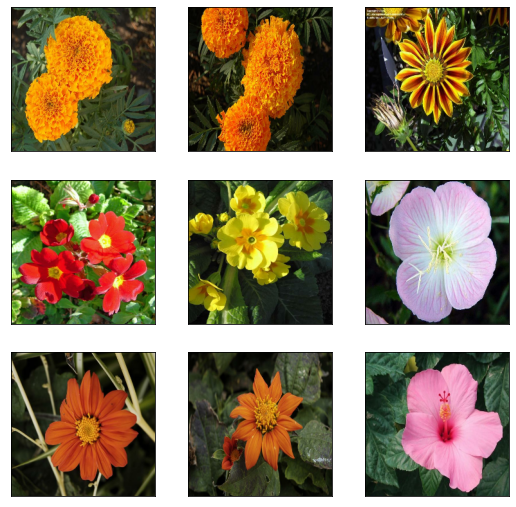

In [ ]:
# code to visualise 3 triplets
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## BUILDING THE SIAMESE NETWORK MODEL

EfficientNetv2B0 is found to be the best transfer learning model for our flowers dataset.

Hence, we use EfficientNetv2B0 as our base CNN along with a global averge pooling layer, batch normalization layer and a final dense layer to produce a 128 dimensional embedding vector for each image. 

Then we compute the distance between the anchor and positive embeddings (d+) and anchor and negative embeddings (d-) for each triplet.

The difference between d+ , d-, and a margin gives us the triplet loss. 

The Siamese network is then trained to minimize this triplet loss.

In [ ]:
# function to compute distance between anchor, positive pair and anchor, negative pair respectively

class DistanceLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [ ]:
# Model architecture to find best model parameters

def build_model_architecture(hl, emb_dimension, num_neuron):

  # Model architecture to produce embeddings

  base_cnn = efficientnet_v2.EfficientNetV2B2(
      weights="imagenet", input_shape=(224,224) + (3,), include_top=False
  )

  base_cnn.trainable = True

  x = tf.keras.layers.GlobalAveragePooling2D()(base_cnn.output)
  x = tf.keras.layers.Dropout(0.2)(x)
  if hl==True:
    x = tf.keras.layers.Dense(num_neuron, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
  output = tf.keras.layers.Dense(emb_dimension, activation='sigmoid')(x)

  embedding = keras.Model(base_cnn.input, output, name="Embedding")

  # Getting anchor, positive and negative input separately from the input layer
  anchor_input = keras.layers.Input(name="anchor", shape=(224,224) + (3,))
  positive_input = keras.layers.Input(name="positive", shape=(224,224) + (3,))
  negative_input = keras.layers.Input(name="negative", shape=(224,224) + (3,))

  distances = DistanceLayer()(
      embedding(efficientnet_v2.preprocess_input(anchor_input)),
      embedding(efficientnet_v2.preprocess_input(positive_input)),
      embedding(efficientnet_v2.preprocess_input(negative_input)),
  )

  # Building the siamese network model that takes triplets as inputs and produces embedding distances as outputs
  siamese_network = keras.Model(
      inputs=[anchor_input, positive_input, negative_input], outputs=distances
  )

  return siamese_network

In [ ]:
# Custom training loop to train our siamese network

class SiameseModel(keras.Model):
    """The Siamese Network model with a custom training and testing (validation) loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that we do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer (Adam) specified in `compile()`
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the weights/parameters
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Updating and returning the training loss metric
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Updating and returning the loss metric
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances between the anchor and the positive sample, and the anchor and the negative sample
        ap_distance, an_distance = self.siamese_network(data)
        # Computing the Triplet Loss by subtracting both distances and adding margin value. Choosing max of loss and 0
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
# Early stopping implementation to reduce over fitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

-----------------------------------------------
Training for parameters: 
Hidden Layer:  False
Embedding Dimension:  50
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4579

319/319 [==============================] - 103s 233ms/step - loss: 0.4579 - val_loss: 0.4412
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4517

319/319 [==============================] - 69s 217ms/step - loss: 0.4517 - val_loss: 0.4390
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4414

319/319 [==============================] - 69s 216ms/step - loss: 0.4414 - val_loss: 0.4310
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.3889

319/319 [==============================] - 69s 216ms/step - loss: 0.3889 - val_loss: 0.3362
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.2665

319/319 [==============================] - 69s 217ms/step - loss: 0.2665 - val_loss: 0.2529
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.2182

319/319 [==============================] - 69s 216ms/step - loss: 0.2182 - val_loss: 0.2343
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.1786

319/319 [==============================] - 69s 217ms/step - loss: 0.1786 - val_loss: 0.2072
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.1557

319/319 [==============================] - 69s 217ms/step - loss: 0.1557 - val_loss: 0.1934
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.1336

319/319 [==============================] - 69s 216ms/step - loss: 0.1336 - val_loss: 0.1897
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.1087

319/319 [==============================] - 69s 217ms/step - loss: 0.1087 - val_loss: 0.1815
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.0918

319/319 [==============================] - 69s 216ms/step - loss: 0.0918 - val_loss: 0.1826
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.0740

319/319 [==============================] - 69s 217ms/step - loss: 0.0740 - val_loss: 0.1758
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.0580

319/319 [==============================] - 69s 216ms/step - loss: 0.0580 - val_loss: 0.1793
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.0474

319/319 [==============================] - 69s 217ms/step - loss: 0.0474 - val_loss: 0.1843
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.0364

319/319 [==============================] - 69s 217ms/step - loss: 0.0364 - val_loss: 0.1753
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.0297

319/319 [==============================] - 69s 216ms/step - loss: 0.0297 - val_loss: 0.1709
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0247

319/319 [==============================] - 69s 216ms/step - loss: 0.0247 - val_loss: 0.1862
Epoch 18/30
319/319 [==============================] - ETA: 0s - loss: 0.0192

319/319 [==============================] - 69s 217ms/step - loss: 0.0192 - val_loss: 0.1733
Epoch 19/30
319/319 [==============================] - ETA: 0s - loss: 0.0135

319/319 [==============================] - 69s 216ms/step - loss: 0.0135 - val_loss: 0.1845
Epoch 20/30
319/319 [==============================] - ETA: 0s - loss: 0.0115

319/319 [==============================] - 69s 216ms/step - loss: 0.0115 - val_loss: 0.1861
Epoch 21/30
319/319 [==============================] - ETA: 0s - loss: 0.0095

319/319 [==============================] - 69s 216ms/step - loss: 0.0095 - val_loss: 0.1908
-----------------------------------------------
Training for parameters: 
Hidden Layer:  False
Embedding Dimension:  100
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4650

319/319 [==============================] - 103s 233ms/step - loss: 0.4650 - val_loss: 0.4509
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4489

319/319 [==============================] - 69s 217ms/step - loss: 0.4489 - val_loss: 0.4500
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4407

319/319 [==============================] - 69s 217ms/step - loss: 0.4407 - val_loss: 0.4264
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.4259

319/319 [==============================] - 69s 217ms/step - loss: 0.4259 - val_loss: 0.3918
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.3261

319/319 [==============================] - 69s 217ms/step - loss: 0.3261 - val_loss: 0.2722
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.2229

319/319 [==============================] - 70s 218ms/step - loss: 0.2229 - val_loss: 0.2150
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.1775

319/319 [==============================] - 69s 217ms/step - loss: 0.1775 - val_loss: 0.2156
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.1505

319/319 [==============================] - 69s 217ms/step - loss: 0.1505 - val_loss: 0.1962
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.1234

319/319 [==============================] - 70s 218ms/step - loss: 0.1234 - val_loss: 0.1893
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.1028

319/319 [==============================] - 69s 217ms/step - loss: 0.1028 - val_loss: 0.1868
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.0850

319/319 [==============================] - 70s 218ms/step - loss: 0.0850 - val_loss: 0.1679
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.0742

319/319 [==============================] - 70s 218ms/step - loss: 0.0742 - val_loss: 0.1652
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.0537

319/319 [==============================] - 69s 217ms/step - loss: 0.0537 - val_loss: 0.1778
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.0481

319/319 [==============================] - 69s 217ms/step - loss: 0.0481 - val_loss: 0.1847
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.0384

319/319 [==============================] - 69s 217ms/step - loss: 0.0384 - val_loss: 0.2107
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.0329

319/319 [==============================] - 69s 217ms/step - loss: 0.0329 - val_loss: 0.1797
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0242

319/319 [==============================] - 70s 218ms/step - loss: 0.0242 - val_loss: 0.1760
-----------------------------------------------
Training for parameters: 
Hidden Layer:  True
Neurons in Hidden Layer:  16
Embedding Dimension:  50
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4772

319/319 [==============================] - 104s 232ms/step - loss: 0.4772 - val_loss: 0.4724
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4892

319/319 [==============================] - 69s 215ms/step - loss: 0.4892 - val_loss: 0.4998
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4703

319/319 [==============================] - 69s 215ms/step - loss: 0.4703 - val_loss: 0.4156
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.3385

319/319 [==============================] - 69s 215ms/step - loss: 0.3385 - val_loss: 0.3175
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.3042

319/319 [==============================] - 69s 215ms/step - loss: 0.3042 - val_loss: 0.2869
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.2766

319/319 [==============================] - 69s 215ms/step - loss: 0.2766 - val_loss: 0.2708
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.2495

319/319 [==============================] - 69s 215ms/step - loss: 0.2495 - val_loss: 0.2572
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.2225

319/319 [==============================] - 69s 214ms/step - loss: 0.2225 - val_loss: 0.2816
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.2031

319/319 [==============================] - 69s 216ms/step - loss: 0.2031 - val_loss: 0.2194
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.1839

319/319 [==============================] - 69s 216ms/step - loss: 0.1839 - val_loss: 0.2057
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.1706

319/319 [==============================] - 68s 214ms/step - loss: 0.1706 - val_loss: 0.2238
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.1543

319/319 [==============================] - 69s 215ms/step - loss: 0.1543 - val_loss: 0.2201
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.1375

319/319 [==============================] - 69s 215ms/step - loss: 0.1375 - val_loss: 0.2011
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.1230

319/319 [==============================] - 69s 215ms/step - loss: 0.1230 - val_loss: 0.1995
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.1097

319/319 [==============================] - 69s 215ms/step - loss: 0.1097 - val_loss: 0.2070
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.0989

319/319 [==============================] - 69s 215ms/step - loss: 0.0989 - val_loss: 0.2005
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0870

319/319 [==============================] - 69s 215ms/step - loss: 0.0870 - val_loss: 0.2180
Epoch 18/30
319/319 [==============================] - ETA: 0s - loss: 0.0738

319/319 [==============================] - 69s 215ms/step - loss: 0.0738 - val_loss: 0.2018
Epoch 19/30
319/319 [==============================] - ETA: 0s - loss: 0.0658

319/319 [==============================] - 69s 215ms/step - loss: 0.0658 - val_loss: 0.1985
Epoch 20/30
319/319 [==============================] - ETA: 0s - loss: 0.0559

319/319 [==============================] - 69s 215ms/step - loss: 0.0559 - val_loss: 0.2236
Epoch 21/30
319/319 [==============================] - ETA: 0s - loss: 0.0489

319/319 [==============================] - 69s 215ms/step - loss: 0.0489 - val_loss: 0.2442
Epoch 22/30
319/319 [==============================] - ETA: 0s - loss: 0.0429

319/319 [==============================] - 69s 215ms/step - loss: 0.0429 - val_loss: 0.2289
Epoch 23/30
319/319 [==============================] - ETA: 0s - loss: 0.0361

319/319 [==============================] - 69s 214ms/step - loss: 0.0361 - val_loss: 0.2538
Epoch 24/30
319/319 [==============================] - ETA: 0s - loss: 0.0299

319/319 [==============================] - 69s 215ms/step - loss: 0.0299 - val_loss: 0.2386
-----------------------------------------------
Training for parameters: 
Hidden Layer:  True
Neurons in Hidden Layer:  32
Embedding Dimension:  50
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4803

319/319 [==============================] - 106s 235ms/step - loss: 0.4803 - val_loss: 0.5000
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.5000

319/319 [==============================] - 70s 218ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4999

319/319 [==============================] - 70s 219ms/step - loss: 0.4999 - val_loss: 0.4996
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.4971

319/319 [==============================] - 70s 218ms/step - loss: 0.4971 - val_loss: 0.4988
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.4776

319/319 [==============================] - 70s 218ms/step - loss: 0.4776 - val_loss: 0.4533
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.4368

319/319 [==============================] - 70s 219ms/step - loss: 0.4368 - val_loss: 0.4099
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.3620

319/319 [==============================] - 70s 218ms/step - loss: 0.3620 - val_loss: 0.3577
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.2817

319/319 [==============================] - 70s 219ms/step - loss: 0.2817 - val_loss: 0.2879
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.1851

319/319 [==============================] - 70s 218ms/step - loss: 0.1851 - val_loss: 0.2521
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.1396

319/319 [==============================] - 70s 218ms/step - loss: 0.1396 - val_loss: 0.2371
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.1006

319/319 [==============================] - 70s 219ms/step - loss: 0.1006 - val_loss: 0.2296
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.0742

319/319 [==============================] - 70s 218ms/step - loss: 0.0742 - val_loss: 0.2355
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.0528

319/319 [==============================] - 70s 219ms/step - loss: 0.0528 - val_loss: 0.2272
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.0422

319/319 [==============================] - 70s 219ms/step - loss: 0.0422 - val_loss: 0.2315
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.0293

319/319 [==============================] - 70s 218ms/step - loss: 0.0293 - val_loss: 0.2337
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.0193

319/319 [==============================] - 70s 218ms/step - loss: 0.0193 - val_loss: 0.2470
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0152

319/319 [==============================] - 70s 218ms/step - loss: 0.0152 - val_loss: 0.2574
Epoch 18/30
319/319 [==============================] - ETA: 0s - loss: 0.0117

319/319 [==============================] - 70s 219ms/step - loss: 0.0117 - val_loss: 0.2546
-----------------------------------------------
Training for parameters: 
Hidden Layer:  True
Neurons in Hidden Layer:  64
Embedding Dimension:  50
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4667

319/319 [==============================] - 106s 235ms/step - loss: 0.4667 - val_loss: 0.4582
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4543

319/319 [==============================] - 70s 218ms/step - loss: 0.4543 - val_loss: 0.4426
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4804

319/319 [==============================] - 70s 218ms/step - loss: 0.4804 - val_loss: 0.4998
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.4909

319/319 [==============================] - 69s 217ms/step - loss: 0.4909 - val_loss: 0.4599
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.4448

319/319 [==============================] - 70s 218ms/step - loss: 0.4448 - val_loss: 0.3955
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.3359

319/319 [==============================] - 70s 218ms/step - loss: 0.3359 - val_loss: 0.2575
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.2388

319/319 [==============================] - 70s 218ms/step - loss: 0.2388 - val_loss: 0.2631
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.1967

319/319 [==============================] - 70s 218ms/step - loss: 0.1967 - val_loss: 0.2431
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.1644

319/319 [==============================] - 70s 219ms/step - loss: 0.1644 - val_loss: 0.2149
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.1347

319/319 [==============================] - 70s 218ms/step - loss: 0.1347 - val_loss: 0.2093
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.1103

319/319 [==============================] - 70s 218ms/step - loss: 0.1103 - val_loss: 0.2007
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.0893

319/319 [==============================] - 69s 217ms/step - loss: 0.0893 - val_loss: 0.1836
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.0710

319/319 [==============================] - 70s 219ms/step - loss: 0.0710 - val_loss: 0.1939
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.0566

319/319 [==============================] - 70s 218ms/step - loss: 0.0566 - val_loss: 0.2010
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.0454

319/319 [==============================] - 70s 217ms/step - loss: 0.0454 - val_loss: 0.2016
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.0363

319/319 [==============================] - 69s 217ms/step - loss: 0.0363 - val_loss: 0.2177
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0288

319/319 [==============================] - 70s 218ms/step - loss: 0.0288 - val_loss: 0.2201
-----------------------------------------------
Training for parameters: 
Hidden Layer:  True
Neurons in Hidden Layer:  16
Embedding Dimension:  100
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4611

319/319 [==============================] - 106s 232ms/step - loss: 0.4611 - val_loss: 0.4403
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4563

319/319 [==============================] - 69s 216ms/step - loss: 0.4563 - val_loss: 0.4459
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4497

319/319 [==============================] - 69s 216ms/step - loss: 0.4497 - val_loss: 0.4401
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.4781

319/319 [==============================] - 69s 216ms/step - loss: 0.4781 - val_loss: 0.4937
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.4788

319/319 [==============================] - 69s 216ms/step - loss: 0.4788 - val_loss: 0.4572
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.4569

319/319 [==============================] - 69s 216ms/step - loss: 0.4569 - val_loss: 0.4353
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.4356

319/319 [==============================] - 69s 216ms/step - loss: 0.4356 - val_loss: 0.3741
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.3186

319/319 [==============================] - 69s 217ms/step - loss: 0.3186 - val_loss: 0.3035
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.2668

319/319 [==============================] - 69s 216ms/step - loss: 0.2668 - val_loss: 0.2518
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.2289

319/319 [==============================] - 69s 215ms/step - loss: 0.2289 - val_loss: 0.2680
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.2065

319/319 [==============================] - 69s 215ms/step - loss: 0.2065 - val_loss: 0.2288
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.1756

319/319 [==============================] - 69s 216ms/step - loss: 0.1756 - val_loss: 0.2386
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.1581

319/319 [==============================] - 69s 215ms/step - loss: 0.1581 - val_loss: 0.2314
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.1332

319/319 [==============================] - 69s 217ms/step - loss: 0.1332 - val_loss: 0.2206
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.1133

319/319 [==============================] - 69s 216ms/step - loss: 0.1133 - val_loss: 0.2143
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.1018

319/319 [==============================] - 69s 216ms/step - loss: 0.1018 - val_loss: 0.2037
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0886

319/319 [==============================] - 69s 216ms/step - loss: 0.0886 - val_loss: 0.1921
Epoch 18/30
319/319 [==============================] - ETA: 0s - loss: 0.0718

319/319 [==============================] - 69s 216ms/step - loss: 0.0718 - val_loss: 0.2164
Epoch 19/30
319/319 [==============================] - ETA: 0s - loss: 0.0640

319/319 [==============================] - 69s 216ms/step - loss: 0.0640 - val_loss: 0.2165
Epoch 20/30
319/319 [==============================] - ETA: 0s - loss: 0.0533

319/319 [==============================] - 69s 217ms/step - loss: 0.0533 - val_loss: 0.2320
Epoch 21/30
319/319 [==============================] - ETA: 0s - loss: 0.0433

319/319 [==============================] - 69s 216ms/step - loss: 0.0433 - val_loss: 0.2381
Epoch 22/30
319/319 [==============================] - ETA: 0s - loss: 0.0337

319/319 [==============================] - 69s 216ms/step - loss: 0.0337 - val_loss: 0.2363
-----------------------------------------------
Training for parameters: 
Hidden Layer:  True
Neurons in Hidden Layer:  32
Embedding Dimension:  100
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4805

319/319 [==============================] - 106s 234ms/step - loss: 0.4805 - val_loss: 0.4609
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4201

319/319 [==============================] - 69s 215ms/step - loss: 0.4201 - val_loss: 0.3561
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.3240

319/319 [==============================] - 69s 214ms/step - loss: 0.3240 - val_loss: 0.3069
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.2880

319/319 [==============================] - 69s 216ms/step - loss: 0.2880 - val_loss: 0.2876
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.2551

319/319 [==============================] - 68s 214ms/step - loss: 0.2551 - val_loss: 0.2834
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.2440

319/319 [==============================] - 69s 216ms/step - loss: 0.2440 - val_loss: 0.2819
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.2219

319/319 [==============================] - 69s 215ms/step - loss: 0.2219 - val_loss: 0.2468
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.2107

319/319 [==============================] - 69s 216ms/step - loss: 0.2107 - val_loss: 0.2337
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.2015

319/319 [==============================] - 69s 216ms/step - loss: 0.2015 - val_loss: 0.2269
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.1832

319/319 [==============================] - 69s 217ms/step - loss: 0.1832 - val_loss: 0.2082
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.1688

319/319 [==============================] - 69s 217ms/step - loss: 0.1688 - val_loss: 0.2181
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.1545

319/319 [==============================] - 69s 217ms/step - loss: 0.1545 - val_loss: 0.1956
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.1387

319/319 [==============================] - 69s 215ms/step - loss: 0.1387 - val_loss: 0.2073
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.1289

319/319 [==============================] - 69s 215ms/step - loss: 0.1289 - val_loss: 0.1873
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.1126

319/319 [==============================] - 69s 216ms/step - loss: 0.1126 - val_loss: 0.1902
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.1008

319/319 [==============================] - 69s 215ms/step - loss: 0.1008 - val_loss: 0.1991
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0915

319/319 [==============================] - 69s 215ms/step - loss: 0.0915 - val_loss: 0.1908
Epoch 18/30
319/319 [==============================] - ETA: 0s - loss: 0.0797

319/319 [==============================] - 69s 215ms/step - loss: 0.0797 - val_loss: 0.1979
Epoch 19/30
319/319 [==============================] - ETA: 0s - loss: 0.0707

319/319 [==============================] - 69s 216ms/step - loss: 0.0707 - val_loss: 0.1965
-----------------------------------------------
Training for parameters: 
Hidden Layer:  True
Neurons in Hidden Layer:  64
Embedding Dimension:  100
-----------------------------------------------
Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4588

319/319 [==============================] - 103s 232ms/step - loss: 0.4588 - val_loss: 0.4451
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4497

319/319 [==============================] - 69s 216ms/step - loss: 0.4497 - val_loss: 0.4416
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4203

319/319 [==============================] - 68s 214ms/step - loss: 0.4203 - val_loss: 0.4077
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.3773

319/319 [==============================] - 69s 216ms/step - loss: 0.3773 - val_loss: 0.3813
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.3144

319/319 [==============================] - 69s 216ms/step - loss: 0.3144 - val_loss: 0.3096
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.2501

319/319 [==============================] - 69s 216ms/step - loss: 0.2501 - val_loss: 0.2587
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.2094

319/319 [==============================] - 69s 217ms/step - loss: 0.2094 - val_loss: 0.2430
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.1876

319/319 [==============================] - 69s 215ms/step - loss: 0.1876 - val_loss: 0.2291
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.1615

319/319 [==============================] - 69s 215ms/step - loss: 0.1615 - val_loss: 0.2258
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.1396

319/319 [==============================] - 69s 216ms/step - loss: 0.1396 - val_loss: 0.2100
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.1180

319/319 [==============================] - 69s 215ms/step - loss: 0.1180 - val_loss: 0.2110
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.1020

319/319 [==============================] - 68s 214ms/step - loss: 0.1020 - val_loss: 0.2112
Epoch 13/30
319/319 [==============================] - ETA: 0s - loss: 0.0881

319/319 [==============================] - 69s 215ms/step - loss: 0.0881 - val_loss: 0.1976
Epoch 14/30
319/319 [==============================] - ETA: 0s - loss: 0.0727

319/319 [==============================] - 69s 215ms/step - loss: 0.0727 - val_loss: 0.2054
Epoch 15/30
319/319 [==============================] - ETA: 0s - loss: 0.0635

319/319 [==============================] - 69s 215ms/step - loss: 0.0635 - val_loss: 0.2126
Epoch 16/30
319/319 [==============================] - ETA: 0s - loss: 0.0520

319/319 [==============================] - 69s 215ms/step - loss: 0.0520 - val_loss: 0.2100
Epoch 17/30
319/319 [==============================] - ETA: 0s - loss: 0.0421

319/319 [==============================] - 69s 215ms/step - loss: 0.0421 - val_loss: 0.2237
Epoch 18/30
319/319 [==============================] - ETA: 0s - loss: 0.0329

319/319 [==============================] - 69s 215ms/step - loss: 0.0329 - val_loss: 0.2114


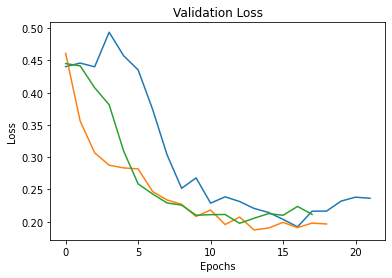

In [ ]:
# Fine tuning
'''● Hidden layers: 0, 1
   ● Neurons in hidden layer: 16, 32, 64
   ● Embedding dimensions: 50, 100'''

losses = []

hl = [False,True]
num_neuron = [16, 32, 64]
emb_dim = [50, 100]

to_perms = [hl]+[emb_dim]+[num_neuron]

perms = list(itertools.product(*to_perms))

cnt = 0
final_perms = []
for i in perms:
    if cnt==0:
        final_perms.append(list(i))
    if cnt>4:
        final_perms.append(list(i))
    cnt = cnt+1

cnt = 0  
for i in final_perms:
  if cnt==2:
    plt.clf()
  elif cnt==5:
    plt.clf()

  print('-----------------------------------------------')
  print('Training for parameters: ')
  print('Hidden Layer: ', i[0])
  if cnt>1:
    print('Neurons in Hidden Layer: ', i[2])
  print('Embedding Dimension: ', i[1])
  print('-----------------------------------------------')


  siamese_network = build_model_architecture(i[0], i[1], i[2])

  # Building and fitting the model
  siamese_model = SiameseModel(siamese_network)
  siamese_model.compile(optimizer=keras.optimizers.Adam(1e-5))
  history = siamese_model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[es])

  losses.append(history.history['val_loss'])

  plt.plot(history.history["val_loss"])
  plt.title('Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.savefig(''+str(cnt)+'_loss.png')

  cnt = cnt+1

In [ ]:
results = pd.DataFrame({'Params': final_perms, 'Accuracy': losses})

## Training the best model

Best model configuration: Hidden layer = False, output dimension = 50

In [ ]:
# Model architecture for best model

base_cnn = efficientnet_v2.EfficientNetV2B2(
      weights="imagenet", input_shape=(224,224) + (3,), include_top=False
  )

base_cnn.trainable = True

x = tf.keras.layers.GlobalAveragePooling2D()(base_cnn.output)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(50, activation='sigmoid')(x)

embedding = keras.Model(base_cnn.input, output, name="Embedding")

  # Getting anchor, positive and negative input separately from the input layer
anchor_input = keras.layers.Input(name="anchor", shape=(224,224) + (3,))
positive_input = keras.layers.Input(name="positive", shape=(224,224) + (3,))
negative_input = keras.layers.Input(name="negative", shape=(224,224) + (3,))

distances = DistanceLayer()(
      embedding(efficientnet_v2.preprocess_input(anchor_input)),
      embedding(efficientnet_v2.preprocess_input(positive_input)),
      embedding(efficientnet_v2.preprocess_input(negative_input)),
  )

  # Building the siamese network model that takes triplets as inputs and produces embedding distances as outputs
siamese_network = keras.Model(
      inputs=[anchor_input, positive_input, negative_input], outputs=distances
  )

In [ ]:
# Building and training the best model
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=keras.optimizers.Adam(1e-5))
history = siamese_model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[es])

Epoch 1/30
319/319 [==============================] - ETA: 0s - loss: 0.4588

319/319 [==============================] - 109s 239ms/step - loss: 0.4588 - val_loss: 0.4561
Epoch 2/30
319/319 [==============================] - ETA: 0s - loss: 0.4423

319/319 [==============================] - 70s 219ms/step - loss: 0.4423 - val_loss: 0.4384
Epoch 3/30
319/319 [==============================] - ETA: 0s - loss: 0.4056

319/319 [==============================] - 70s 218ms/step - loss: 0.4056 - val_loss: 0.3802
Epoch 4/30
319/319 [==============================] - ETA: 0s - loss: 0.2831

319/319 [==============================] - 70s 218ms/step - loss: 0.2831 - val_loss: 0.2523
Epoch 5/30
319/319 [==============================] - ETA: 0s - loss: 0.2028

319/319 [==============================] - 70s 218ms/step - loss: 0.2028 - val_loss: 0.2252
Epoch 6/30
319/319 [==============================] - ETA: 0s - loss: 0.1566

319/319 [==============================] - 70s 219ms/step - loss: 0.1566 - val_loss: 0.2096
Epoch 7/30
319/319 [==============================] - ETA: 0s - loss: 0.1236

319/319 [==============================] - 70s 218ms/step - loss: 0.1236 - val_loss: 0.1905
Epoch 8/30
319/319 [==============================] - ETA: 0s - loss: 0.0973

319/319 [==============================] - 70s 219ms/step - loss: 0.0973 - val_loss: 0.1993
Epoch 9/30
319/319 [==============================] - ETA: 0s - loss: 0.0790

319/319 [==============================] - 70s 219ms/step - loss: 0.0790 - val_loss: 0.1965
Epoch 10/30
319/319 [==============================] - ETA: 0s - loss: 0.0627

319/319 [==============================] - 70s 219ms/step - loss: 0.0627 - val_loss: 0.2065
Epoch 11/30
319/319 [==============================] - ETA: 0s - loss: 0.0499

319/319 [==============================] - 70s 219ms/step - loss: 0.0499 - val_loss: 0.1910
Epoch 12/30
319/319 [==============================] - ETA: 0s - loss: 0.0407

319/319 [==============================] - 70s 219ms/step - loss: 0.0407 - val_loss: 0.2019


Text(0, 0.5, 'Loss')

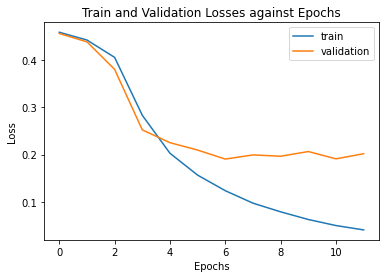

In [ ]:
# plotting training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Losses against Epochs')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## PREDICTION

Once our Siamese Network is trained, it should produce embeddings such that embeddings of images belonging to the same class are closer than embeddings of images of dissimilar classes.

We use a support set (image, label pairs) to help our model make predictions. Since our support set consists of 5 samples per class, it is an example of 5-shot prediction.

We pass every image in the support set through the trained network to obtain their corresponding embeddings. 

Then we pass each test sample (never seen by the model before) to obtain its embedding.

We compute the cosine similarity of the test embedding with each of the support embeddings. The test, support pair with lowest cosine similarity (highest degree of similairty) found. The label of that support sample is our final prediction.

In [ ]:
# code to plot predicted image (support image having highest similairty) vs actual test image side by side
def visualize_prediction(real, pred):
    """Visualize a few triplets from the supplied batches."""
    real = tf.squeeze(real)
    pred = tf.squeeze(pred)
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(1, 2)
    show(axs[0], pred)
    show(axs[1], real)

predicted class: 25 vs actual class: 57
max similarity of -0.9920469522476196 found with class 25
###########################################################################
predicted class: 3 vs actual class: 73
max similarity of -0.9830548167228699 found with class 3
###########################################################################
predicted class: 2 vs actual class: 2
max similarity of -0.9944114685058594 found with class 2
###########################################################################
predicted class: 54 vs actual class: 54
max similarity of -0.9968507289886475 found with class 54
###########################################################################
predicted class: 19 vs actual class: 74
max similarity of -0.9866325259208679 found with class 19
###########################################################################
predicted class: 40 vs actual class: 40
max similarity of -0.9912508726119995 found with class 40
#####################################

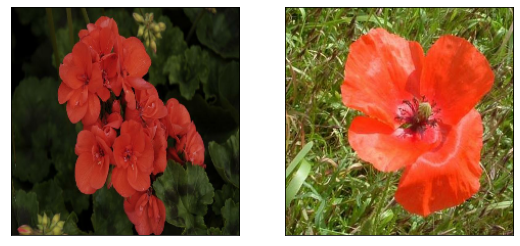

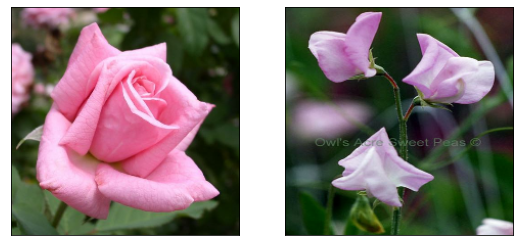

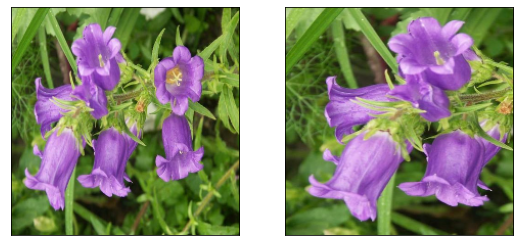

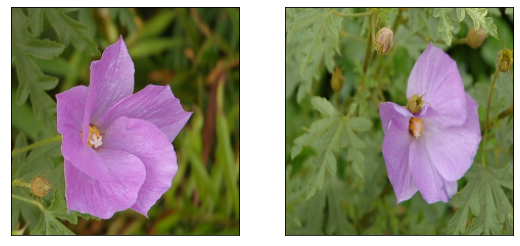

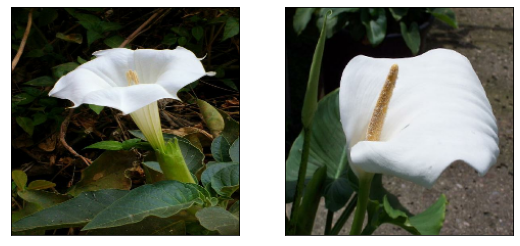

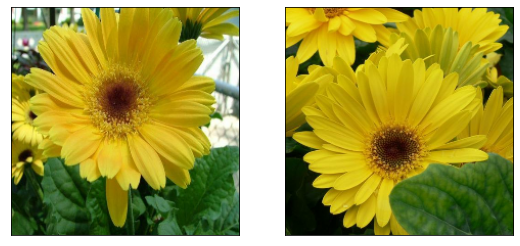

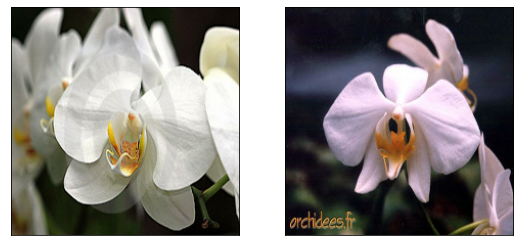

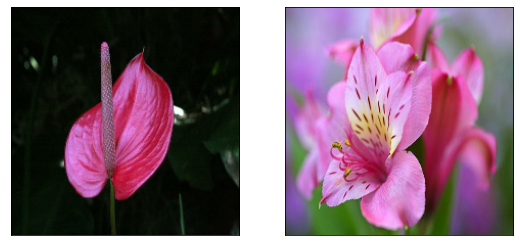

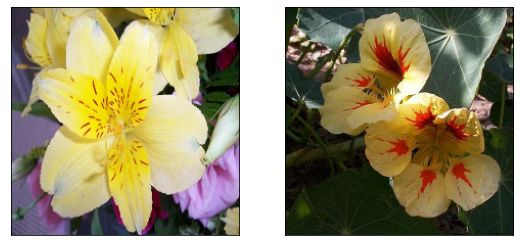

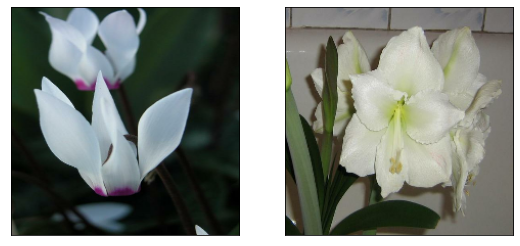

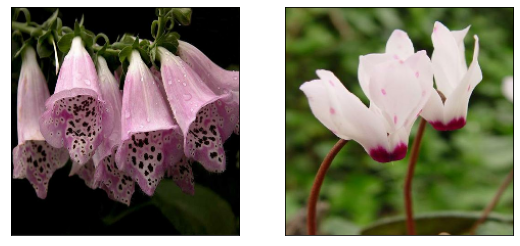

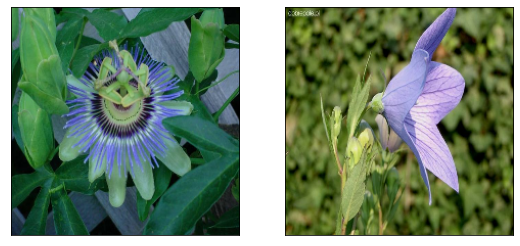

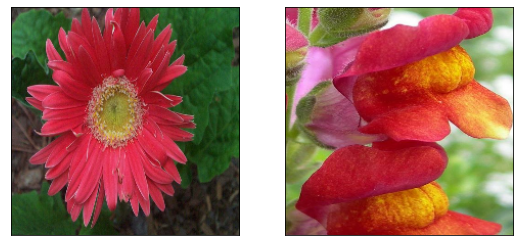

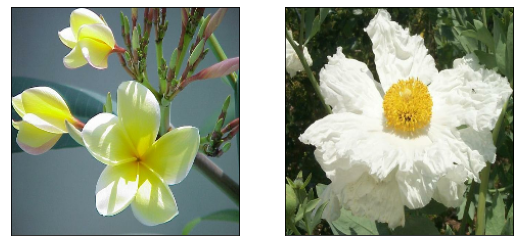

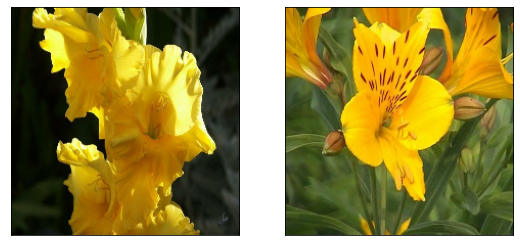

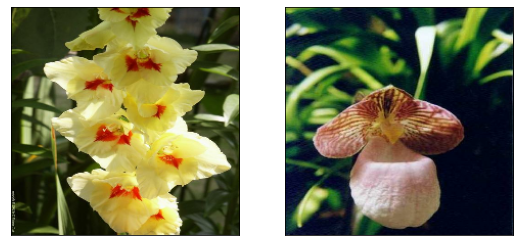

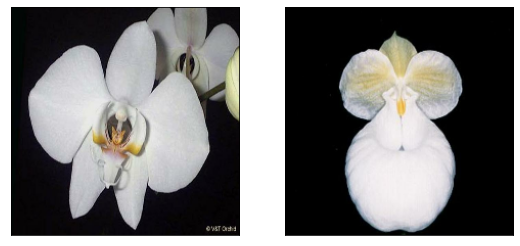

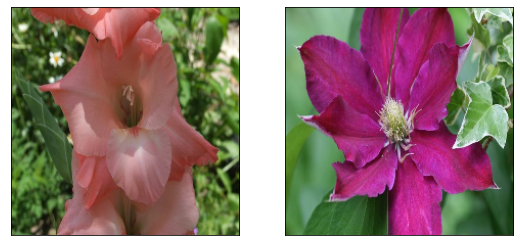

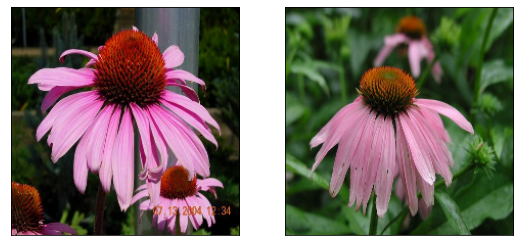

In [ ]:
# custom testing loop
support_labels = []
support_samples = []
support_embeddings = []

# Obtaining embeddings for all images in the support set
for i in range(support_set.shape[0]):
  image_path =  support_set['image_path'].iloc[i]
  label = support_set['image_label'].iloc[i]
  support_image = preprocess_image(image_path)
  support_labels.append(label)
  support_samples.append(support_image)
  support_ds = [support_image]
  support_dataset = tf.data.Dataset.from_tensor_slices(support_ds)
  support_dataset = support_dataset.batch(1, drop_remainder=False)
  support_im = next(iter(support_dataset))
  support_embedding = embedding(efficientnet_v2.preprocess_input(support_im))
  support_embeddings.append(support_embedding)

# inital prediction accuracy
accuracy = 0

test_set = shuffle(test_set)

# making predictions on 500 test samples
for j in range(500):
  test_image_path =  test_set['image_path'].iloc[j]
  actual_label = test_set['image_label'].iloc[j]
  test_image = preprocess_image(test_image_path)
  
  # creating tensorflow dataset for test image and batching it to obtain same dimension as model input i.e. (None, 224, 224, 3) where 'None' is the Batch dimension
  test_ds = [test_image]
  test_dataset = tf.data.Dataset.from_tensor_slices(test_ds)
  test_dataset = test_dataset.batch(1, drop_remainder=False)
  test_im = next(iter(test_dataset))

  # obtaining embedding for test image
  test_embedding = embedding(efficientnet_v2.preprocess_input(test_im))
  
  # finding and storing cosine similarity for each (test, support_image) pair
  cosine_similarities = []
  for k in range(len(support_embeddings)):

    # pair_distance = tf.reduce_sum(tf.square(test_embedding - support_embeddings[k]), -1)
    # cosine_similarities.append(pair_distance)
    pair_similarity = keras.losses.cosine_similarity(test_embedding, support_embeddings[k], axis =1).numpy()[0]
    cosine_similarities.append(pair_similarity)

  # finding (test, support_image) pair with lowest cosine similarity (highest degree of similarity)
  max_similarity = min(cosine_similarities)
  index = cosine_similarities.index(max_similarity)

  # predicted class = label of support image which has highest similairty with test image
  predicted_class = support_labels[index]

  # if predicted class is same as actual class, it is a correct prediction
  if predicted_class == actual_label:
    accuracy += 1

  # printing and visualizing prediction results
  print(f"predicted class: {predicted_class} vs actual class: {actual_label}")
  print(f"max similarity of {max_similarity} found with class {predicted_class}")
  print("###########################################################################")
  if j < 20:
    visualize_prediction(support_samples[index], test_image)

In [ ]:
# printing our average classification accuracy
num_test_samples = 500
test_accuracy = accuracy/num_test_samples
print(f"Obatined averge classification accuracy of {test_accuracy*100}% on {num_test_samples} test images")

Obatined averge classification accuracy of 29.2% on 500 test images
